In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm
import pandas as pd
import seawater

%matplotlib inline

In [2]:
# Select time we want to look at
ctime = pd.Timestamp(2022, 4, 18, 12, 0, 0)
ctime_str = ctime.strftime("%Y-%m-%d %H:%M:%S")

# Subset the model to the GulfCores area
lons = [-83.77, -79.64]
lats = [22.8, 24.9]

# Sort the lons and lats so they are in monotonically increasing order 
lons.sort()
lats.sort()

In [3]:
# Convert lons (-180, 180) into lons (0, 360)
glons = np.mod(lons, 360)
glons

array([276.23, 280.36])

# Load and munge RTOFS

In [4]:
# Use the xarray open_dataset function to access the dataset via opendap. Set lon and lat to coordinates for easy plotting and select the center time above and grab only the top 1000m
rtofs = xr.open_dataset("https://tds.marine.rutgers.edu/thredds/dodsC/cool/rtofs/rtofs_us_east_scraped").set_coords(['lon', 'lat']).sel(time=ctime, depth=slice(0, 1000))
rtofs

<xarray.Dataset>
Dimensions:      (depth: 33, y: 1710, x: 742)
Coordinates:
  * depth        (depth) float32 0.0 2.0 4.0 6.0 8.0 ... 700.0 800.0 900.0 1e+03
  * y            (y) int32 1 2 3 4 5 6 7 ... 1704 1705 1706 1707 1708 1709 1710
  * x            (x) int32 1 2 3 4 5 6 7 8 9 ... 735 736 737 738 739 740 741 742
    time         datetime64[ns] 2022-04-18T12:00:00
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
Data variables:
    date         float64 ...
    u            (depth, y, x) float32 ...
    v            (depth, y, x) float32 ...
    temperature  (depth, y, x) float32 ...
    salinity     (depth, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...

In [5]:
# Save rtofs lon and lat as variables to speed up indexing calculation
grid_lons = rtofs.lon.values[0,:]
grid_lats = rtofs.lat.values[:,0]
grid_x = rtofs.x.values
grid_y = rtofs.y.values

# Find x, y index of area we want to subset
lons_ind = np.interp(lons, grid_lons, grid_x)
lats_ind = np.interp(lats, grid_lats, grid_y)
lons_ind, lats_ind

(array([203.87505344, 255.49941985]), array([293.83395134, 322.53707977]))

In [6]:
# We use np.floor on the first index of each slice and np.ceiling on the second index of each slice 
# in order to widen the area of the extent slightly around each index. 
# This returns a float so we have to broadcast the datatype to an integer in order to use .isel
extent = np.floor(lons_ind[0]).astype(int), np.ceil(lons_ind[1]).astype(int), np.floor(lats_ind[0]).astype(int), np.ceil(lats_ind[1]).astype(int)
extent

(203, 256, 293, 323)

In [7]:
# Use the xarray .isel selector on x/y since we know the exact indexes we want to slice
rtofs = rtofs.isel(
    x=slice(extent[0], extent[1]),
    y=slice(extent[2], extent[3])
    )
rtofs

<xarray.Dataset>
Dimensions:      (depth: 33, y: 30, x: 53)
Coordinates:
  * depth        (depth) float32 0.0 2.0 4.0 6.0 8.0 ... 700.0 800.0 900.0 1e+03
  * y            (y) int32 294 295 296 297 298 299 ... 318 319 320 321 322 323
  * x            (x) int32 204 205 206 207 208 209 ... 251 252 253 254 255 256
    time         datetime64[ns] 2022-04-18T12:00:00
    lat          (y, x) float32 22.81 22.81 22.81 22.81 ... 24.93 24.93 24.93
    lon          (y, x) float32 -83.76 -83.68 -83.6 ... -79.76 -79.68 -79.6
Data variables:
    date         float64 2.022e+07
    u            (depth, y, x) float32 ...
    v            (depth, y, x) float32 ...
    temperature  (depth, y, x) float32 ...
    salinity     (depth, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...

# Use xr.apply_ufunc to apply a function over all dimensions

In [8]:
rtofs["pressure"] = xr.apply_ufunc(seawater.eos80.pres, rtofs.depth, rtofs.lat)
rtofs["density"] = xr.apply_ufunc(seawater.eos80.dens, rtofs.salinity, rtofs.temperature, rtofs.pressure)
rtofs

<xarray.Dataset>
Dimensions:      (depth: 33, y: 30, x: 53)
Coordinates:
  * depth        (depth) float32 0.0 2.0 4.0 6.0 8.0 ... 700.0 800.0 900.0 1e+03
  * y            (y) int32 294 295 296 297 298 299 ... 318 319 320 321 322 323
  * x            (x) int32 204 205 206 207 208 209 ... 251 252 253 254 255 256
    time         datetime64[ns] 2022-04-18T12:00:00
    lat          (y, x) float32 22.81 22.81 22.81 22.81 ... 24.93 24.93 24.93
    lon          (y, x) float32 -83.76 -83.68 -83.6 ... -79.76 -79.68 -79.6
Data variables:
    date         float64 2.022e+07
    u            (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    v            (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    temperature  (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    salinity     (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    pressure     (depth, y, x) float32 0.0 0.0 0.0 ... 1.009e+03 1.009e+03
    density      (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...

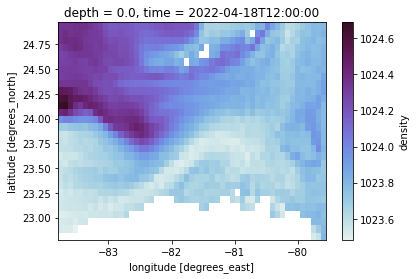

In [9]:
# Use xarrays built-in plotting wrappers around matplotlib to plot temperature
rtofs.density.sel(depth=0).plot(x="lon", y="lat", cmap=cm.dense)

In [10]:
# Save rtofs lon and lat as variables to speed up indexing calculation
grid_lons = rtofs.lon.values[0,:]
grid_lats = rtofs.lat.values[:,0]
grid_x = rtofs.x.values
grid_y = rtofs.y.values

# Load and munge GOFS

In [11]:
# Use the xarray open_dataset function to access the dataset via opendap. Set lon and lat to coordinates for easy plotting and select the center time above and grab only the top 1000m
gofs = xr.open_dataset("https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0", drop_variables="tau").sel(time=ctime, depth=slice(0,1000), lon=slice(glons[0], glons[1]), lat=slice(lats[0], lats[1])).rename(
    {"water_temp": "temperature",
     "water_u": "u", 
     "water_v": "v",
     "surf_el": "ssh"
    }
)
gofs

<xarray.Dataset>
Dimensions:            (lat: 52, lon: 52, depth: 33)
Coordinates:
  * lat                (lat) float64 22.84 22.88 22.92 ... 24.8 24.84 24.88
  * lon                (lon) float64 276.2 276.3 276.4 ... 280.2 280.2 280.3
    time               datetime64[ns] 2022-04-18T12:00:00
  * depth              (depth) float64 0.0 2.0 4.0 6.0 ... 800.0 900.0 1e+03
Data variables:
    ssh                (lat, lon) float32 ...
    temperature        (depth, lat, lon) float32 ...
    water_temp_bottom  (lat, lon) float32 ...
    salinity           (depth, lat, lon) float32 ...
    salinity_bottom    (lat, lon) float32 ...
    u                  (depth, lat, lon) float32 ...
    water_u_bottom     (lat, lon) float32 ...
    v                  (depth, lat, lon) float32 ...
    water_v_bottom     (lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    history:                   archv2ncdf2d
    comment:                   p-grid
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In [12]:
gofs["lon"] = np.mod(gofs["lon"]+180, 360)-180

In [13]:
gofs["pressure"] = xr.apply_ufunc(seawater.eos80.pres, gofs.depth, gofs.lat)
gofs["density"] = xr.apply_ufunc(seawater.eos80.dens, gofs.salinity, gofs.temperature, gofs.pressure)
gofs

<xarray.Dataset>
Dimensions:            (lat: 52, lon: 52, depth: 33)
Coordinates:
  * lat                (lat) float64 22.84 22.88 22.92 ... 24.8 24.84 24.88
  * lon                (lon) float64 -83.76 -83.68 -83.6 ... -79.76 -79.68
    time               datetime64[ns] 2022-04-18T12:00:00
  * depth              (depth) float64 0.0 2.0 4.0 6.0 ... 800.0 900.0 1e+03
Data variables:
    ssh                (lat, lon) float32 nan nan nan nan ... 0.0 0.045 0.083
    temperature        (depth, lat, lon) float32 nan nan nan nan ... nan nan nan
    water_temp_bottom  (lat, lon) float32 nan nan nan nan ... 5.061 5.069 4.95
    salinity           (depth, lat, lon) float32 nan nan nan nan ... nan nan nan
    salinity_bottom    (lat, lon) float32 nan nan nan nan ... 34.74 34.75 34.72
    u                  (depth, lat, lon) float32 nan nan nan nan ... nan nan nan
    water_u_bottom     (lat, lon) float32 nan nan nan ... -0.003 -0.01 -0.024
    v                  (depth, lat, lon) float32 nan nan nan nan ... nan nan nan
    water_v_bottom     (lat, lon) float32 nan nan nan nan ... 0.023 0.034 0.031
    pressure           (depth, lat) float64 0.0 0.0 0.0 ... 1.009e+03 1.009e+03
    density            (depth, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    history:                   archv2ncdf2d
    comment:                   p-grid
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

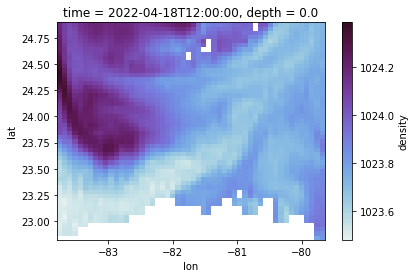

In [14]:
# Use xarrays built-in plotting wrappers around matplotlib to plot temperature
gofs.density.sel(depth=0).plot(x="lon", y="lat", cmap=cm.dense)

# AMSEAS

In [15]:
# Load and munge AMSEAS
am = xr.open_dataset("https://www.ncei.noaa.gov/thredds-coastal/dodsC/ncom_amseas_agg/AmSeas_Dec_17_2020_to_Current_best.ncd").sel(time=ctime, depth=slice(0,1000), lon=slice(glons[0], glons[1]), lat=slice(lats[0], lats[1])).rename(
    {
        "water_temp": "temperature", 
        "water_u": "u",
        "water_v": "v",
        "surf_el": "ssh"
    }
)
am["lon"] = np.mod(am["lon"]+180, 360)-180
am

<xarray.Dataset>
Dimensions:                (lon: 124, lat: 63, depth: 33, time1: 16)
Coordinates:
  * lon                    (lon) float64 -83.77 -83.73 -83.7 ... -79.7 -79.67
  * lat                    (lat) float64 22.83 22.86 22.9 ... 24.83 24.86 24.9
  * depth                  (depth) float64 0.0 2.0 4.0 6.0 ... 800.0 900.0 1e+03
    time                   datetime64[ns] 2022-04-18T12:00:00
    time_run               datetime64[ns] ...
  * time1                  (time1) datetime64[ns] 2021-03-03 ... 2021-12-17T2...
Data variables: (12/16)
    ssh                    (lat, lon) float32 ...
    water_w                (depth, lat, lon) float32 ...
    surf_atm_press         (lat, lon) float32 ...
    time1_run              (time1) datetime64[ns] ...
    time_offset            datetime64[ns] ...
    time1_offset           (time1) datetime64[ns] ...
    ...                     ...
    surf_wnd_stress_gridx  (lat, lon) float32 ...
    surf_wnd_stress_gridy  (lat, lon) float32 ...
    surf_roughness         (lat, lon) float32 ...
    surf_temp_flux         (lat, lon) float32 ...
    surf_salt_flux         (lat, lon) float32 ...
    surf_solar_flux        (lat, lon) float32 ...
Attributes: (12/21)
    classification_level:      
    distribution_statement:    Approved for public release; distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               not applicable
    Conventions:               CF-1.4, NAVO_netcdf_v1.1
    ...                        ...
    publisher_name:            OceanNOMADS@noaa.gov
    title:                     NAVO NCOM Relocatable Model: American Seas Reg...
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:AmSeas_Dec_17_2020_to_Current

In [16]:
am["pressure"] = xr.apply_ufunc(seawater.eos80.pres, am.depth, am.lat)
am["density"] = xr.apply_ufunc(seawater.eos80.dens, am.salinity, am.temperature, am.pressure)
am

<xarray.Dataset>
Dimensions:                (lon: 124, lat: 63, depth: 33, time1: 16)
Coordinates:
  * lon                    (lon) float64 -83.77 -83.73 -83.7 ... -79.7 -79.67
  * lat                    (lat) float64 22.83 22.86 22.9 ... 24.83 24.86 24.9
  * depth                  (depth) float64 0.0 2.0 4.0 6.0 ... 800.0 900.0 1e+03
    time                   datetime64[ns] 2022-04-18T12:00:00
    time_run               datetime64[ns] 2022-04-18
  * time1                  (time1) datetime64[ns] 2021-03-03 ... 2021-12-17T2...
Data variables: (12/18)
    ssh                    (lat, lon) float32 0.5951 0.5951 ... 0.5081 0.5295
    water_w                (depth, lat, lon) float32 ...
    surf_atm_press         (lat, lon) float32 999.6 999.6 999.6 ... 1e+03 1e+03
    time1_run              (time1) datetime64[ns] 2021-03-03 ... 2021-12-17
    time_offset            datetime64[ns] 2020-12-15T12:00:00
    time1_offset           (time1) datetime64[ns] 2020-12-15 ... 2020-12-15T2...
    ...                     ...
    surf_roughness         (lat, lon) float32 4.657e-10 4.657e-10 ... 4.657e-10
    surf_temp_flux         (lat, lon) float32 -3.049e-05 ... -4.825e-05
    surf_salt_flux         (lat, lon) float32 6.409e-07 5.493e-07 ... 1.648e-06
    surf_solar_flux        (lat, lon) float32 3.108e-05 3.11e-05 ... 4.579e-05
    pressure               (depth, lat) float64 0.0 0.0 ... 1.009e+03 1.009e+03
    density                (depth, lat, lon) float64 1.024e+03 1.024e+03 ... nan
Attributes: (12/21)
    classification_level:      
    distribution_statement:    Approved for public release; distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               not applicable
    Conventions:               CF-1.4, NAVO_netcdf_v1.1
    ...                        ...
    publisher_name:            OceanNOMADS@noaa.gov
    title:                     NAVO NCOM Relocatable Model: American Seas Reg...
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:AmSeas_Dec_17_2020_to_Current

# Copernicus

In [17]:
# Load Copernicus data
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store


USERNAME = 'maristizabalvar'
PASSWORD = 'MariaCMEMS2018'
DATASET_ID = 'global-analysis-forecast-phy-001-024'

data_store = copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)

# Downloading and reading Copernicus grid
cmems = xr.open_dataset(data_store, drop_variables='tau').rename(
    {
        'thetao': 'temperature', 
        'so': 'salinity',
        'latitude': 'lat',
        'longitude': 'lon',
        'uo': 'u',
        'vo': 'v'
    }
)
cmems = cmems.sel(time=ctime, depth=slice(0,1000), lon=slice(lons[0], lons[1]), lat=slice(lats[0], lats[1]))
cmems

<xarray.Dataset>
Dimensions:      (lon: 50, lat: 25, depth: 35)
Coordinates:
  * lon          (lon) float32 -83.75 -83.67 -83.58 ... -79.83 -79.75 -79.67
  * lat          (lat) float32 22.83 22.92 23.0 23.08 ... 24.67 24.75 24.83
  * depth        (depth) float32 0.494 1.541 2.646 3.819 ... 643.6 763.3 902.3
    time         datetime64[ns] 2022-04-18T12:00:00
Data variables:
    mlotst       (lat, lon) float32 ...
    zos          (lat, lon) float32 ...
    bottomT      (lat, lon) float32 ...
    sithick      (lat, lon) float32 ...
    siconc       (lat, lon) float32 ...
    usi          (lat, lon) float32 ...
    vsi          (lat, lon) float32 ...
    temperature  (depth, lat, lon) float32 ...
    salinity     (depth, lat, lon) float32 ...
    u            (depth, lat, lon) float32 ...
    v            (depth, lat, lon) float32 ...
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2022/04/21 00:19:35 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR PSY4QV3R1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [18]:
cmems["pressure"] = xr.apply_ufunc(seawater.eos80.pres, cmems.depth, cmems.lat)
cmems["density"] = xr.apply_ufunc(seawater.eos80.dens, cmems.salinity, cmems.temperature, cmems.pressure)
cmems

<xarray.Dataset>
Dimensions:      (lon: 50, lat: 25, depth: 35)
Coordinates:
  * lon          (lon) float32 -83.75 -83.67 -83.58 ... -79.83 -79.75 -79.67
  * lat          (lat) float32 22.83 22.92 23.0 23.08 ... 24.67 24.75 24.83
  * depth        (depth) float32 0.494 1.541 2.646 3.819 ... 643.6 763.3 902.3
    time         datetime64[ns] 2022-04-18T12:00:00
Data variables: (12/13)
    mlotst       (lat, lon) float32 9.919 9.308 7.324 7.019 ... 17.4 19.23 23.35
    zos          (lat, lon) float32 0.3134 0.3104 0.3113 ... 0.173 0.213 0.2432
    bottomT      (lat, lon) float32 23.73 26.83 27.42 ... 6.199 6.243 6.254
    sithick      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    siconc       (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    usi          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    temperature  (depth, lat, lon) float32 27.18 27.35 27.58 ... nan nan nan
    salinity     (depth, lat, lon) float32 36.13 36.14 36.16 ... nan nan nan
    u            (depth, lat, lon) float32 -0.2704 -0.2271 -0.2026 ... nan nan
    v            (depth, lat, lon) float32 -0.1123 -0.2112 -0.105 ... nan nan
    pressure     (depth, lat) float32 0.499 0.499 0.499 ... 910.4 910.4 910.4
    density      (depth, lat, lon) float32 1.024e+03 1.023e+03 ... nan nan
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2022/04/21 00:19:35 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR PSY4QV3R1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [19]:
def transect2rtofs(pts, grid_lons, grid_lats, grid_x, grid_y):
    # if not grid_x:
    #     grid_x = np.arange(0, len(grid_lons))
    # if not grid_y:
    #     grid_y = np.arange(0, len(grid_lats))
    
    # Convert points to x and y index for rtofs
    # Use piecewise linear interpolation (np.interp) to find the partial index (float instead of an int) of the points (lon,lat) we are calculating would lie
    # on the x,y grid for RTOFS
    # We pass the following:
    # np.interp(x, grid_lon, grid_x)
    # np.interp(y, grid_lat, grid_y)
    lonidx = np.interp(pts[:,0], grid_lons, grid_x)
    latidx = np.interp(pts[:,1], grid_lats, grid_y)
    return lonidx, latidx

In [20]:
def calculate_transect(start, end, npts):
    from pyproj import Geod
    g = Geod(ellps="WGS84")
    pts = g.inv_intermediate(start[0], start[1], end[0], end[1], npts) 
    return np.column_stack([pts.lons, pts.lats])

In [21]:
from hurricanes.plotting import map_add_ticks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_map(da, cmap, vrange=None, title=None, figsize=(20,12), sname=None, dpi=300):   
    ctime = pd.to_datetime(da.time.values)
    ctimestr = ctime.strftime("%Y%m%dT%H%M%SZ")
    
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw=dict(projection=ccrs.Mercator())
    )
    
    edgecolor = 'black'
    landcolor = 'tan'
    
    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    
    LAND = cfeature.GSHHSFeature(scale='full')
    
    # Axes properties and features
    # ax.set_extent(extent)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(LAND, edgecolor=edgecolor, facecolor=landcolor)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(state_lines, edgecolor=edgecolor)
    ax.add_feature(cfeature.BORDERS)
    
    # Fill dictionary for keyword arguments
    cargs = {}
    cargs['transform'] = ccrs.PlateCarree()
    cargs['extend'] = 'both'
    cargs['cmap'] = cmap
    
    if vrange:
        vmin = vrange[0]
        vmax = vrange[1]
        vstep = vrange[2]
    else:
        vmin = np.floor(np.nanpercentile(da, 2))
        vmax = np.ceil(np.nanpercentile(da, 98))
        vstep = (vmax-vmin)/12

    cargs['vmin'] = vmin
    cargs['vmax'] = vmax
    cargs['levels'] = np.arange(vmin, vmax+vstep, vstep)

    # Plot filled contour of data variable
    h = ax.contourf(da['lon'], da['lat'], da.squeeze(), **cargs)
    axins = inset_axes(ax,  # here using axis of the lowest plot
    width="2.5%",  # width = 5% of parent_bbox width
    height="100%",  # height : 340% good for a (4x4) Grid
    loc='lower left',
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
    )
    
    # ax.plot(tlons_1, tlats_1, 'r-.', transform=ccrs.PlateCarree(), linewidth=4)
    # ax.plot(tlons_2, tlats_2, 'r-.', transform=ccrs.PlateCarree(), linewidth=4)
    # ax.grid(zorder=40)
    # ax.grid(draw_labels=True)
    
    # Colorbar
    cb = fig.colorbar(h, cax=axins)
    cb.ax.tick_params(labelsize=15)
    cb.set_label(f'{da.name.title()} ({da.units})', fontsize=16, weight='bold')
    
    # Title and axes
    if title:
        title = f"{title}: {da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"
    else:
        title = f"{da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"   
        
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=18, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=18, fontweight="bold")
    
    # Ticks
    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    map_add_ticks(ax, [da["lon"].min(), da["lon"].max(), da["lat"].min(), da["lat"].max()])
    
    if sname:
        sname = f"{sname}_{da.name}_map_{ctimestr}.png"
        plt.savefig(sname, dpi=dpi, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)
        
    return ax

In [22]:
def plot_transect(ds, var, cmap, levels=None, xaxis="lon", title=None, ax=None, cbar=False, fontfrac=1, contour=None, xlabel=None, ylabel=None, sname=None, dpi=300):
    var = ds[var]
    # var_name = ' '.join(var.standard_name.split("_")).title()
    try:
        var_units = var.units
    except AttributeError:
            var_units = ''
    ctime = pd.to_datetime(var.time.values)
    ctimestr = ctime.strftime("%Y%m%dT%H%M%SZ")

    if not ax:
        fig, ax = plt.subplots(
            figsize=(30, 12),
        )

    h = var.plot(ax=ax, x=xaxis, y="depth", levels=levels, cmap=cmap, extend="both",  add_colorbar=False, add_labels=False)
    
    if contour:
        ax.contour(ds[xaxis], ds['depth'], var, contour, colors='k')
    
    if cbar:
        # cb = plt.colorbar(h, ax=ax, orientation="vertical")
        cb = plt.colorbar(h, **cbar)
        cb.set_label(label=f"{var.name.title()} ({var_units})", size=14*fontfrac, weight='bold')
        cb.ax.tick_params(labelsize=12*fontfrac)

    ax.set_ylim([500, 0])
    plt.setp(ax.get_xticklabels(), fontsize=16*fontfrac)
    plt.setp(ax.get_yticklabels(), fontsize=16*fontfrac)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=18*fontfrac, fontweight="bold")
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=18*fontfrac, fontweight="bold")
    
    if title:
        ax.set_title(title, fontsize=24*fontfrac, fontweight="bold")
        
    if sname:
        sname = f"{sname}_{var.name}_{ctimestr}.png"
        plt.savefig(sname, dpi=dpi, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)
    return ax

In [23]:
# Straits of Florida
title = "Straits of Florida (Cuba to Key West)"
start = -81.80, 23.2
end = -81.80, 24.5
points = 500
depth_spacing = 1

# Contour levels
levels_salinity = np.arange(35.5, 36.6, .1)
levels_temperature = np.arange(10, 29, 1)
levels_u = np.arange(-1.5, 1.6, .1)
levels_v = np.arange(-1.5, 1.6, .1)
levels_density = np.arange(1022, 1031, 1)

In [24]:
# Calculate transect line between the start point and end point
# returns all points as a numpy array with lon in the first column and lat in the second column
pts = calculate_transect(start, end, points)
    
# Convert to the x, y indexes so we can work with the RTOFS model
lonidx, latidx = transect2rtofs(pts, grid_lons, grid_lats, grid_x=rtofs.x.values, grid_y=rtofs.y.values)

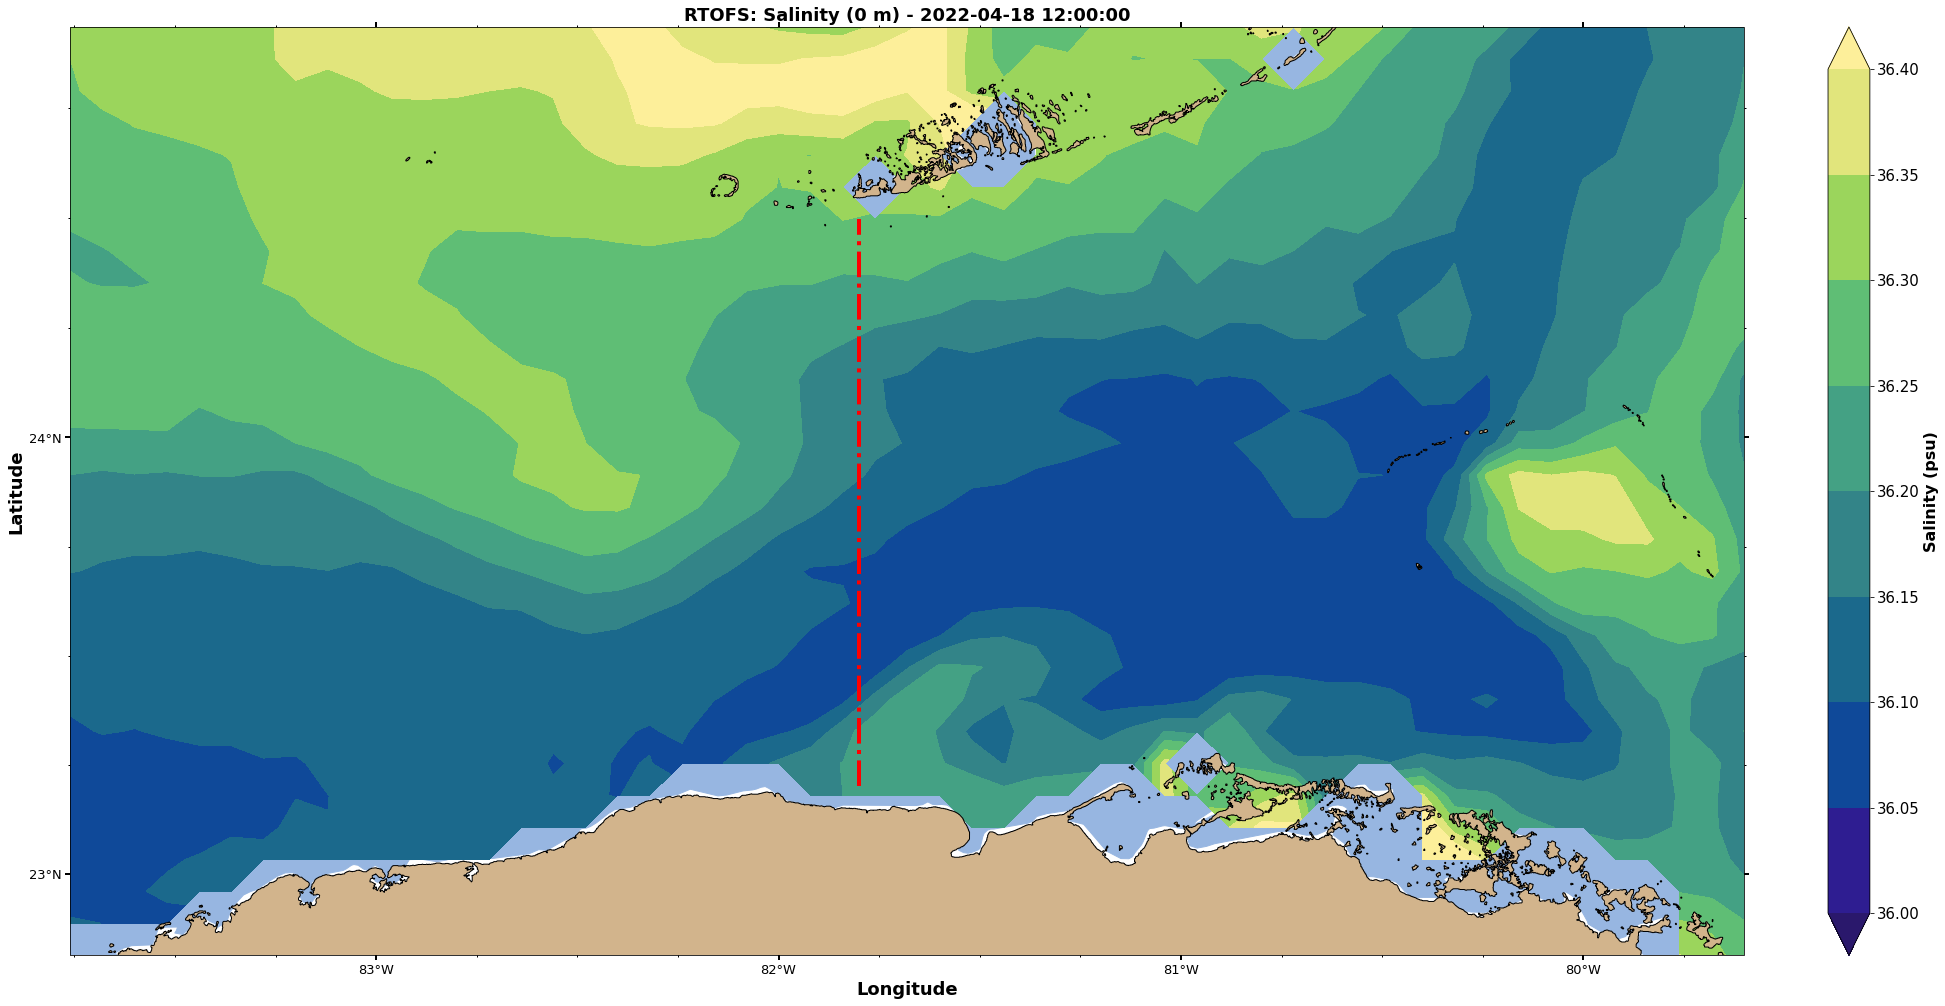

In [25]:
ax = plot_map(rtofs["salinity"].sel(depth=0), cm.haline, (36, 36.4, .05), title="RTOFS", figsize=(30,20))
ax.plot(pts[:,0], pts[:,1], 'r-.', linewidth=4, transform=ccrs.PlateCarree())
plt.savefig('florida_straits_transect_map.png', dpi=300, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)

In [26]:
# Interpolate RTOFS Transect
rds = rtofs.interp(
    x=xr.DataArray(lonidx, dims="point"),
    y=xr.DataArray(latidx, dims="point"),
    depth=xr.DataArray(np.arange(0, rtofs.depth.max()+depth_spacing, depth_spacing), dims="depth")
)
# rds

# Interpolate GOFS Transect
gds = gofs.interp(
    lon=xr.DataArray(pts[:,0], dims="point"),
    lat=xr.DataArray(pts[:,1], dims="point"),
    depth=xr.DataArray(np.arange(0, gofs.depth.max()+depth_spacing, depth_spacing), dims="depth")
)
# gds

# Interpolate AMSEAS Transect
ads = am.interp(
    lon=xr.DataArray(pts[:,0], dims="point"),
    lat=xr.DataArray(pts[:,1], dims="point"),
    depth=xr.DataArray(np.arange(0, am.depth.max()+depth_spacing, depth_spacing), dims="depth")
)
# ads

# Interpolate Copernicus Transect
cds = cmems.interp(
    lon=xr.DataArray(pts[:,0], dims="point"),
    lat=xr.DataArray(pts[:,1], dims="point"),
    depth=xr.DataArray(np.arange(0, cmems.depth.max()+depth_spacing, depth_spacing), dims="depth")
)
# cds

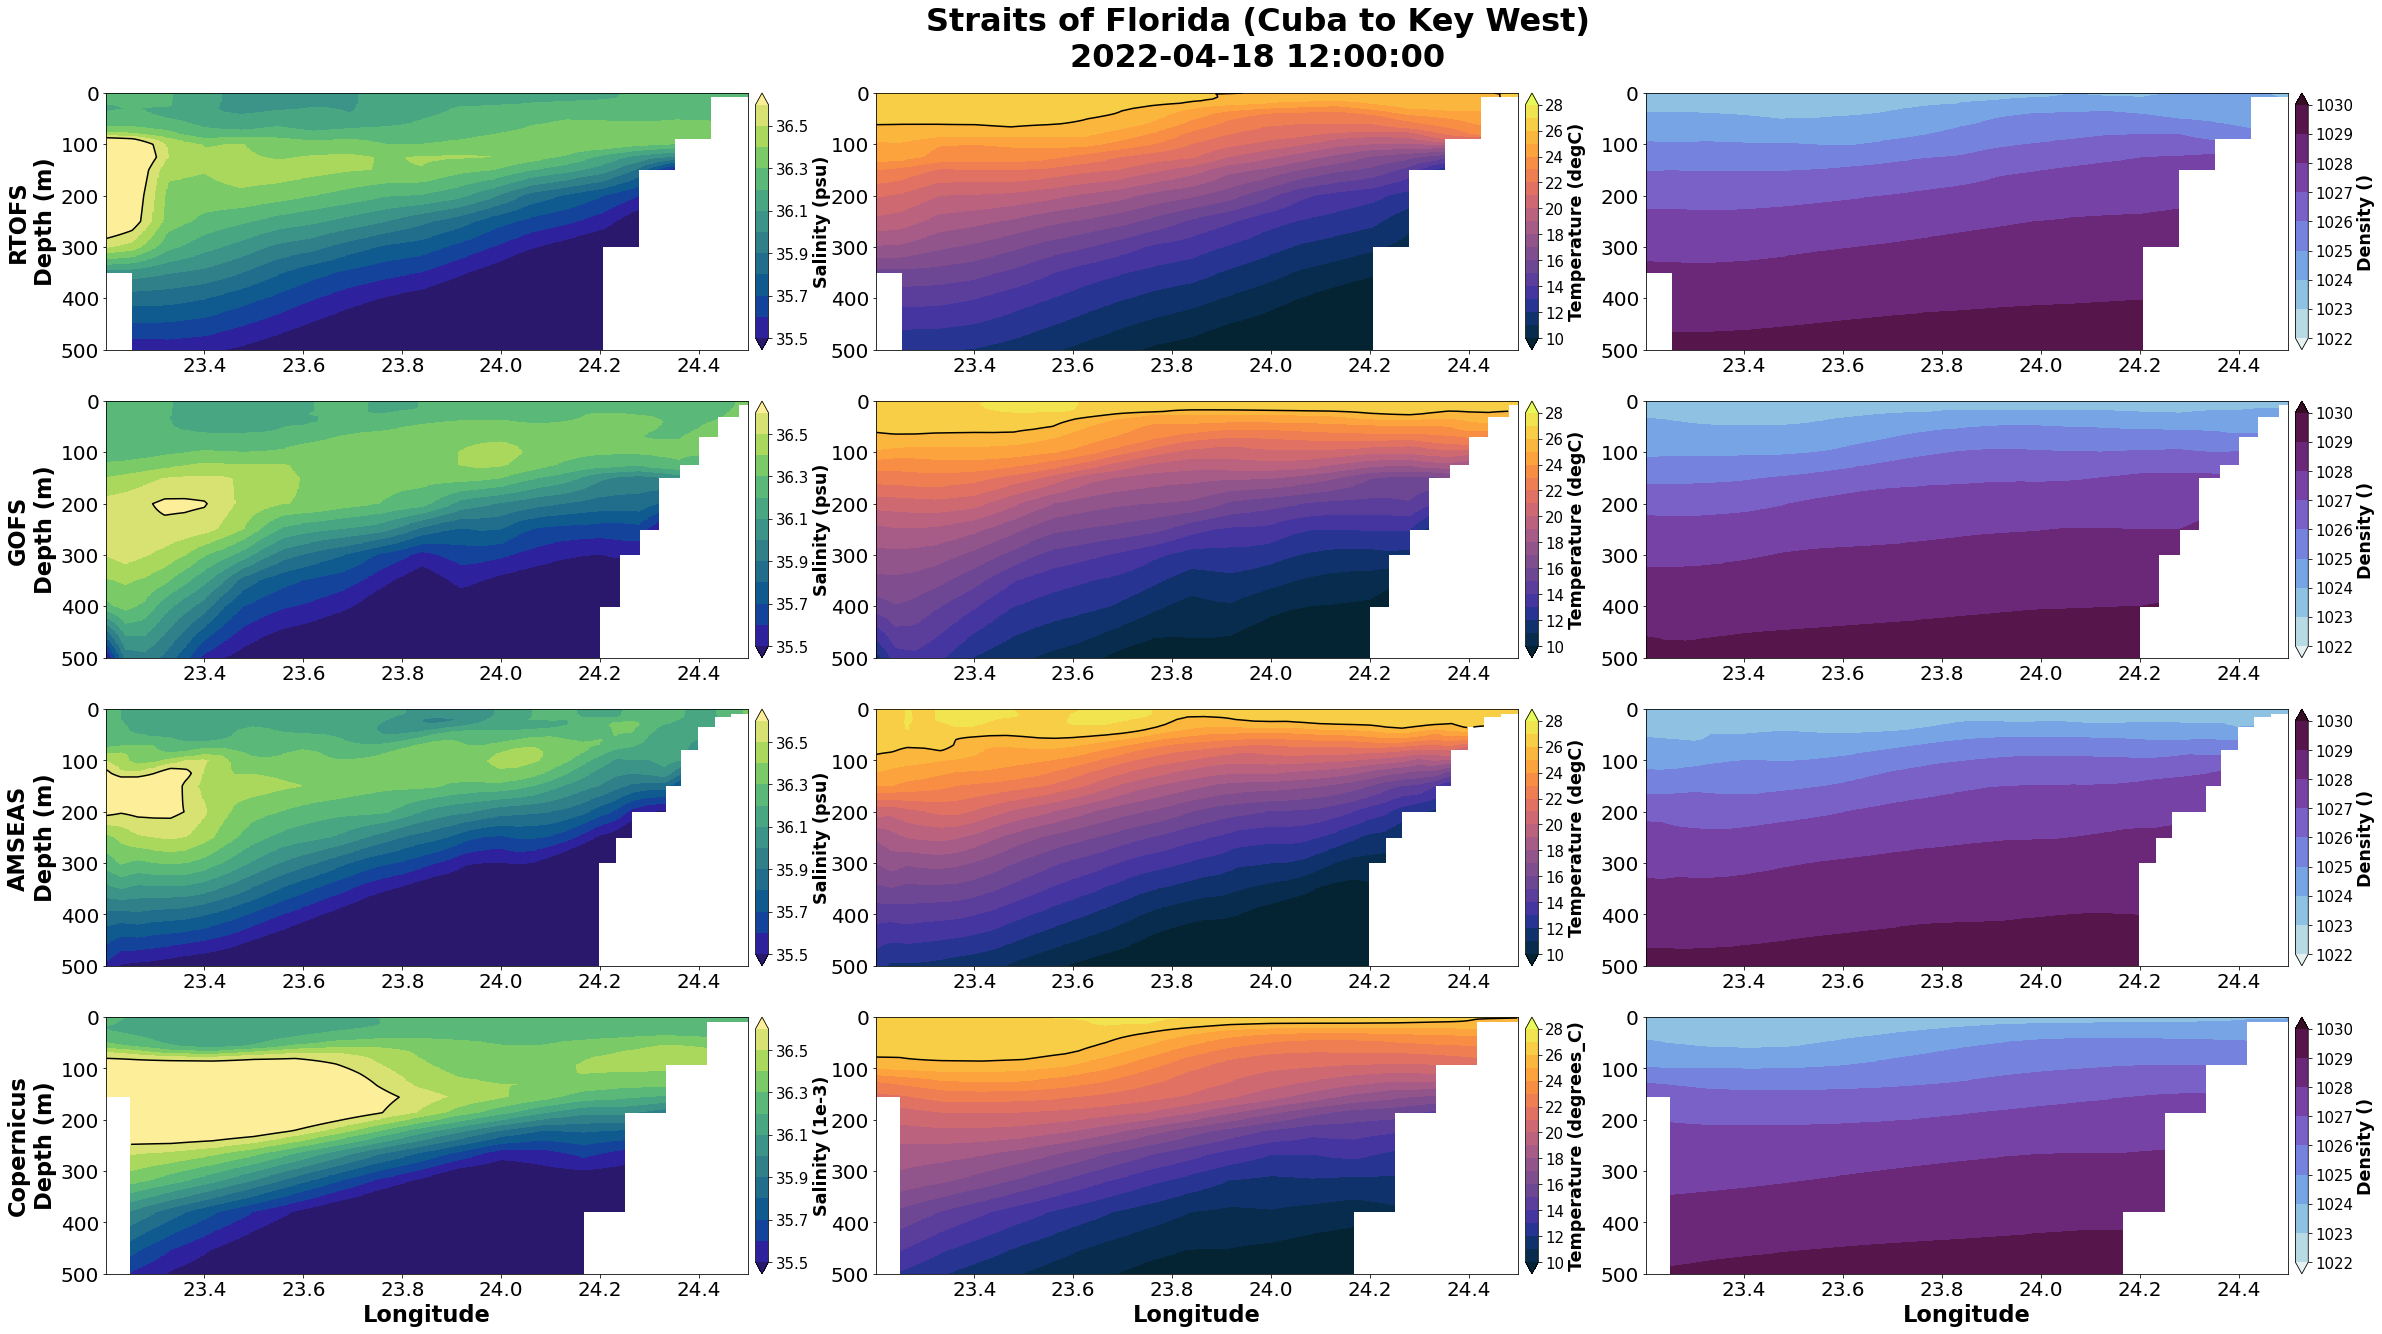

In [27]:
fig, ax = plt.subplots(4, 3, figsize=(40,20))
plot_transect(rds, "salinity", cm.haline, xaxis="lat", levels=levels_salinity, ax=ax[0,0], cbar=dict(ax=ax[0,0], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[36.6], ylabel="RTOFS\nDepth (m)")
plot_transect(gds, "salinity", cm.haline, xaxis="lat", levels=levels_salinity, ax=ax[1,0], cbar=dict(ax=ax[1,0], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[36.6],ylabel="GOFS\nDepth (m)")
plot_transect(ads, "salinity", cm.haline, xaxis="lat", levels=levels_salinity, ax=ax[2,0], cbar=dict(ax=ax[2,0], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[36.6],ylabel="AMSEAS\nDepth (m)")
plot_transect(cds, "salinity", cm.haline, xaxis="lat", levels=levels_salinity, ax=ax[3,0], cbar=dict(ax=ax[3,0], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[36.6], xlabel="Longitude", ylabel="Copernicus\nDepth (m)")

plot_transect(rds, "temperature", cm.thermal, xaxis="lat", levels=levels_temperature, ax=ax[0,1], cbar=dict(ax=ax[0,1], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(gds, "temperature", cm.thermal, xaxis="lat", levels=levels_temperature, ax=ax[1,1], cbar=dict(ax=ax[1,1], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(ads, "temperature", cm.thermal, xaxis="lat", levels=levels_temperature, ax=ax[2,1], cbar=dict(ax=ax[2,1], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(cds, "temperature", cm.thermal, xaxis="lat", levels=levels_temperature, ax=ax[3,1], cbar=dict(ax=ax[3,1], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26], xlabel="Longitude")

plot_transect(rds, "density", cm.dense, xaxis="lat", levels=levels_density, ax=ax[0,2], cbar=dict(ax=ax[0,2], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(gds, "density", cm.dense, xaxis="lat", levels=levels_density, ax=ax[1,2], cbar=dict(ax=ax[1,2], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(ads, "density", cm.dense, xaxis="lat", levels=levels_density, ax=ax[2,2], cbar=dict(ax=ax[2,2], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26])
plot_transect(cds, "density", cm.dense, xaxis="lat", levels=levels_density, ax=ax[3,2], cbar=dict(ax=ax[3,2], orientation='vertical', pad=0.01), fontfrac=1.25, contour=[26], xlabel="Longitude")

plt.suptitle(f"{title}\n{ctime_str}", fontsize=32, fontweight="bold")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    top=0.92, 
                    wspace=0.0075, 
                    hspace=0.2)
plt.savefig('florida_straits_tsd.png', dpi=300, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)

In [28]:
rds

<xarray.Dataset>
Dimensions:      (point: 500, depth: 1001)
Coordinates:
    time         datetime64[ns] 2022-04-18T12:00:00
    lat          (point) float64 23.2 23.21 23.21 23.21 ... 24.49 24.49 24.5
    lon          (point) float64 -81.8 -81.8 -81.8 -81.8 ... -81.8 -81.8 -81.8
    x            (point) float64 228.5 228.5 228.5 228.5 ... 228.5 228.5 228.5
    y            (point) float64 299.3 299.3 299.4 299.4 ... 316.9 317.0 317.0
  * depth        (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 997.0 998.0 999.0 1e+03
Dimensions without coordinates: point
Data variables:
    date         float64 2.022e+07
    u            (depth, point) float64 -0.0255 -0.02517 -0.02484 ... nan nan
    v            (depth, point) float64 0.04901 0.05101 0.05301 ... nan nan nan
    temperature  (depth, point) float64 26.82 26.82 26.83 26.83 ... nan nan nan
    salinity     (depth, point) float64 36.21 36.21 36.21 36.21 ... nan nan nan
    pressure     (depth, point) float64 0.0 0.0 0.0 ... 1.009e+03 1.009e+03
    density      (depth, point) float64 1.024e+03 1.024e+03 ... nan nan
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

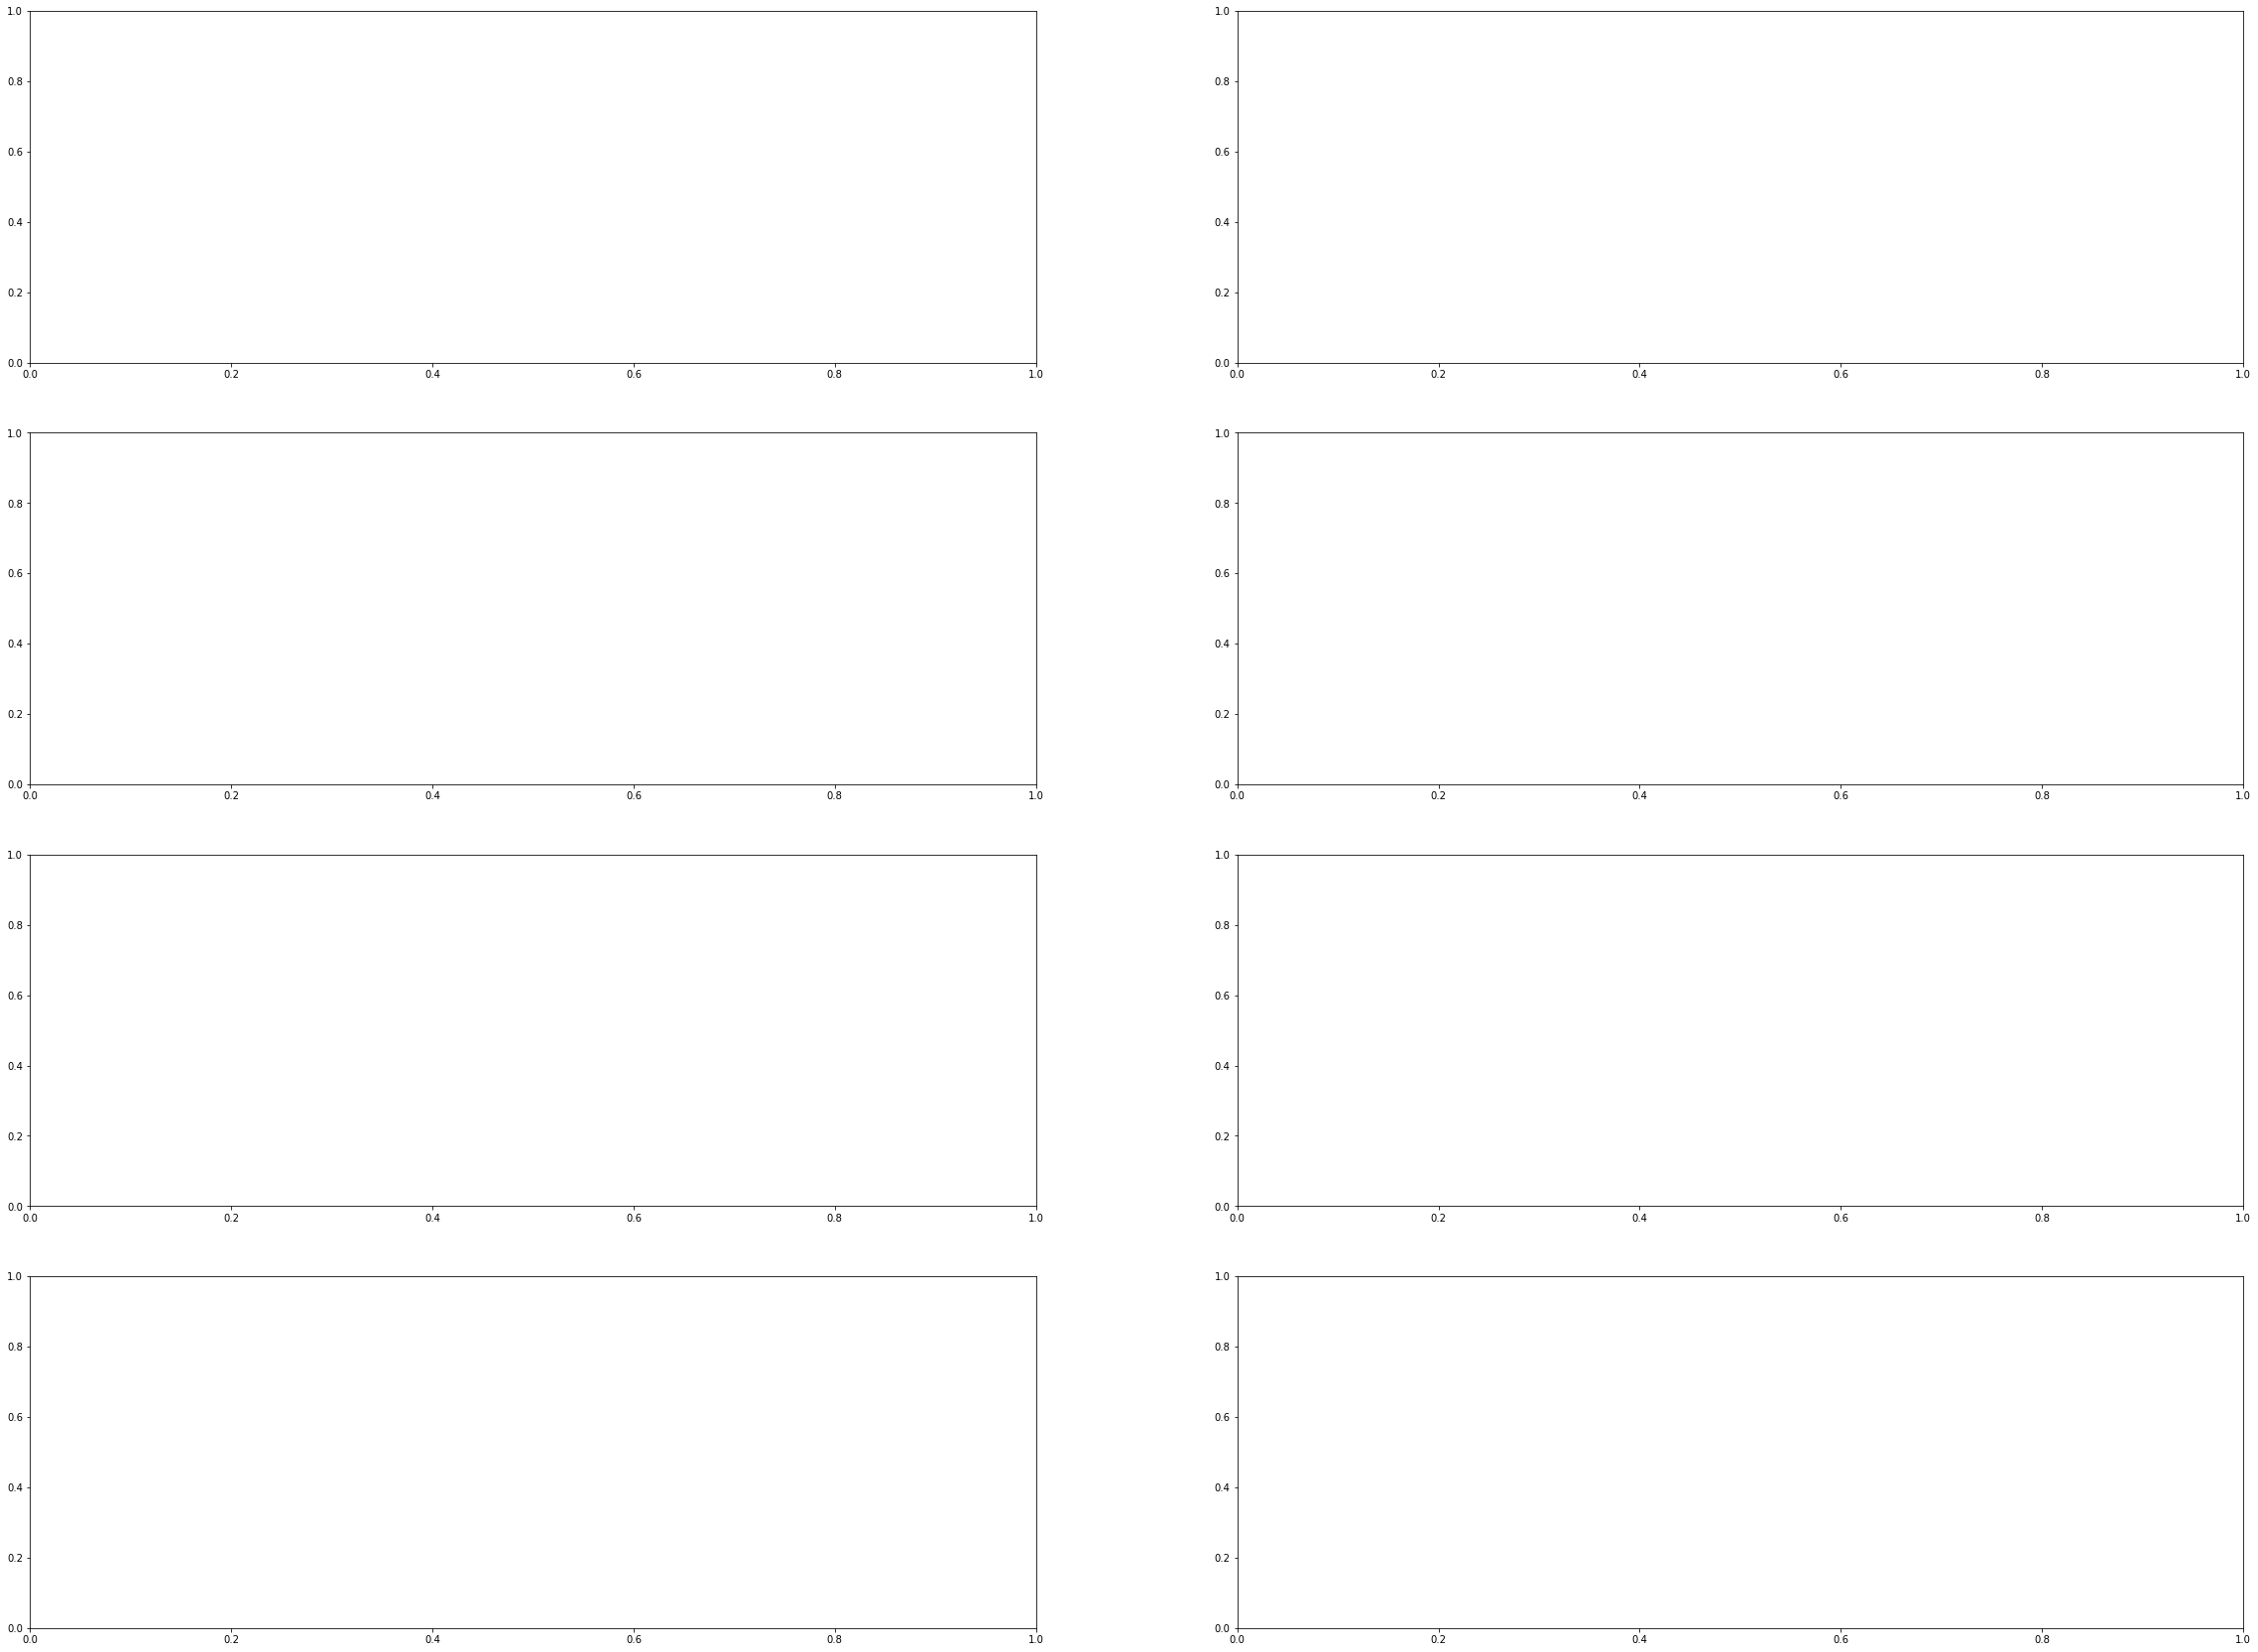

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(40,30))
plot_transect(rds, "u", cm.balance, levels=levels_u, title="Eastward Velocity", ax=ax[0,0], cbar=dict(ax=ax[0,0], orientation='vertical', pad=0.01), fontfrac=1.5, ylabel="RTOFS\nDepth (m)")
plot_transect(gds, "u", cm.balance, levels=levels_u,  ax=ax[1,0], cbar=dict(ax=ax[1,0], orientation='vertical', pad=0.01), fontfrac=1.5, ylabel="GOFS\nDepth (m)")
plot_transect(ads, "u", cm.balance, levels=levels_u, ax=ax[2,0], cbar=dict(ax=ax[2,0], orientation='vertical', pad=0.01), fontfrac=1.5, ylabel="AMSEAS\nDepth (m)")
plot_transect(cds, "u", cm.balance, levels=levels_u, ax=ax[3,0], cbar=dict(ax=ax[3,0], orientation='vertical', pad=0.01), fontfrac=1.5, xlabel="Longitude", ylabel="Copernicus\nDepth (m)")

plot_transect(rds, "v", cm.balance, levels=levels_v, title="Northward Velocity", ax=ax[0,1], cbar=dict(ax=ax[0,1], orientation='vertical', pad=0.01), fontfrac=1.5)
plot_transect(gds, "v", cm.balance, levels=levels_v, ax=ax[1,1], cbar=dict(ax=ax[1,1], orientation='vertical', pad=0.01), fontfrac=1.5)
plot_transect(ads, "v", cm.balance, levels=levels_v, ax=ax[2,1], cbar=dict(ax=ax[2,1], orientation='vertical', pad=0.01), fontfrac=1.5)
plot_transect(cds, "v", cm.balance, levels=levels_v, ax=ax[3,1], cbar=dict(ax=ax[3,1], orientation='vertical', pad=0.01), fontfrac=1.5, xlabel="Longitude")


plt.suptitle(f"{title}\n{ctime_str}", fontsize=32, fontweight="bold")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    top=0.94, 
                    wspace=0.005, 
                    hspace=0.1)
plt.savefig('florida_straits_velocities.png', dpi=300, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)

# Salinity

## 0m

In [ ]:
plot_map(rtofs["salinity"].sel(depth=0), cm.haline, (36, 36.4, .05), title="RTOFS", figsize=(30,20), sname="florida_rtofs_0m")
plot_map(gofs["salinity"].sel(depth=0), cm.haline, (36, 36.4, .05), title="GOFS", figsize=(30,20), sname="florida_gofs_0m")
plot_map(am["salinity"].sel(depth=0), cm.haline, (36, 36.4, .05), title="AMSEAS", figsize=(30,20), sname="florida_amseas_0m")
plot_map(cmems["salinity"].sel(depth=0, method='nearest'), cm.haline, (36, 36.4, .05), title="CMEMS", figsize=(30,20), sname="florida_cmems_0m")

## 100m

In [ ]:
plot_map(rtofs["salinity"].sel(depth=100), cm.haline, (36, 36.7, .05), title="RTOFS", figsize=(30,20), sname="florida_rtofs_100m")
plot_map(gofs["salinity"].sel(depth=100), cm.haline, (36, 36.7, .05), title="GOFS", figsize=(30,20), sname="florida_gofs_100m")
plot_map(am["salinity"].sel(depth=100), cm.haline, (36, 36.7, .05), title="AMSEAS", figsize=(30,20), sname="florida_amseas_100m")
plot_map(cmems["salinity"].sel(depth=100, method='nearest'), cm.haline, (36, 36.7, .05), title="CMEMS", figsize=(30,20), sname="florida_cmems_100m")

# Temperature

## 0m

In [ ]:
plot_map(rtofs["temperature"].sel(depth=0), cm.thermal, (24, 29, .5), title="RTOFS", figsize=(30,20), sname="florida_rtofs_0m")
plot_map(gofs["temperature"].sel(depth=0), cm.thermal, (24, 29, .5), title="GOFS", figsize=(30,20), sname="florida_gofs_0m")
plot_map(am["temperature"].sel(depth=0), cm.thermal, (24, 29, .5), title="AMSEAS", figsize=(30,20), sname="florida_amseas_0m")
plot_map(cmems["temperature"].sel(depth=0, method='nearest'), cm.thermal, (24, 29, .5), title="CMEMS", figsize=(30,20), sname="florida_cmems_0m")

## 100m

In [ ]:
plot_map(rtofs["temperature"].sel(depth=100), cm.thermal, (18, 27, 1), title="RTOFS", figsize=(30,20), sname="florida_rtofs_100m")
plot_map(gofs["temperature"].sel(depth=100), cm.thermal, (18, 27, 1), title="GOFS", figsize=(30,20), sname="florida_gofs_100m")
plot_map(am["temperature"].sel(depth=100), cm.thermal, (18, 27, 1), title="AMSEAS", figsize=(30,20), sname="florida_am_100m")
plot_map(cmems["temperature"].sel(depth=100, method='nearest'), cm.thermal, (18, 27, 1), title="CMEMS", figsize=(30,20), sname="florida_cmems_100m")

In [ ]:
def plot_map_with_quiver(da, cmap, vrange=None, title=None, figsize=(20,12), sname=None, dpi=300):
    ctime = pd.to_datetime(da.time.values)
    ctimestr = ctime.strftime("%Y%m%dT%H%M%SZ")
    from oceans.ocfis import spdir2uv, uv2spdir
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw=dict(projection=ccrs.Mercator())
    )
    
    edgecolor = 'black'
    landcolor = 'tan'
    
    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    
    LAND = cfeature.GSHHSFeature(scale='full')
    
    # Axes properties and features
    # ax.set_extent(extent)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(LAND, edgecolor=edgecolor, facecolor=landcolor)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(state_lines, edgecolor=edgecolor)
    ax.add_feature(cfeature.BORDERS)
    
    # Fill dictionary for keyword arguments
    cargs = {}
    cargs['transform'] = ccrs.PlateCarree()
    cargs['extend'] = 'both'
    cargs['cmap'] = cmap
    
    if vrange:
        vmin = vrange[0]
        vmax = vrange[1]
        vstep = vrange[2]
    else:
        vmin = np.floor(np.nanpercentile(da, 2))
        vmax = np.ceil(np.nanpercentile(da, 98))
        vstep = (vmax-vmin)/12

    cargs['vmin'] = vmin
    cargs['vmax'] = vmax
    cargs['levels'] = np.arange(vmin, vmax+vstep, vstep)

    # Plot filled contour of data variable
    h = ax.contourf(da['lon'], da['lat'], da.squeeze(), **cargs)
    axins = inset_axes(ax,  # here using axis of the lowest plot
    width="2.5%",  # width = 5% of parent_bbox width
    height="100%",  # height : 340% good for a (4x4) Grid
    loc='lower left',
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
    )
    
    # if coarsen:
    #     try:
    #         qds = ds.coarsen(lon=coarsen, boundary='pad').mean().coarsen(lat=coarsen, boundary='pad').mean()
    #         mesh = True
    #     except ValueError:
    #         qds = ds.coarsen(x=coarsen, boundary='pad').mean().coarsen(y=coarsen, boundary='pad').mean()
    #         mesh = False

    angle, speed = uv2spdir(da['u'], da['v'])  # convert u/v to angle and speed
    u, v = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
        np.ones_like(speed),
        angle,
        deg=True
    )

    qargs = {}
    qargs['scale'] = 50
    qargs['headwidth'] = 5
    qargs['headlength'] = 4
    qargs['headaxislength'] = 3
    qargs['transform'] = ccrs.PlateCarree()

    # if mesh:
    # lons, lats = np.meshgrid(da['lon'], da['lat'])
    # q = ax.quiver(lons, lats, u, v, **qargs)
    # else:
    q = ax.quiver(da.lon.squeeze().data, da.lat.squeeze().data, u.squeeze(), v.squeeze(), **qargs)
    # return q
    
    # ax.plot(tlons_1, tlats_1, 'r-.', transform=ccrs.PlateCarree(), linewidth=4)
    # ax.plot(tlons_2, tlats_2, 'r-.', transform=ccrs.PlateCarree(), linewidth=4)
    # ax.grid(zorder=40)
    # ax.grid(draw_labels=True)
    
    # Colorbar
    cb = fig.colorbar(h, cax=axins)
    cb.ax.tick_params(labelsize=15)
    cb.set_label(f'{da.name.title()} ({da.units})', fontsize=16, weight='bold')
    
    # Title and axes
    if title:
        title = f"{title}: {da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"
    else:
        title = f"{da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"   
        
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=18, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=18, fontweight="bold")
    
    # Ticks
    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    map_add_ticks(ax, [da["lon"].min(), da["lon"].max(), da["lat"].min(), da["lat"].max()])
    
    if sname:
        sname = f"{sname}_{da.name}_quiver_map_{ctimestr}.png"
        plt.savefig(sname, dpi=dpi, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# rtofs = rtofs.coarsen()
# gofs = gofs.coarsen()
# am = am.coarsen()
trtofs = rtofs.coarsen(x=2, boundary='pad').mean().coarsen(y=2, boundary='pad').mean().set_coords(['u', 'v'])
tgofs = gofs.coarsen(lon=3, boundary="pad").mean().coarsen(lat=3, boundary="pad").mean().set_coords(['u', 'v'])
tam = am.coarsen(lon=5, boundary="pad").mean().coarsen(lat=5, boundary="pad").mean().set_coords(['u', 'v'])
tcmems = cmems.coarsen(lon=2, boundary="pad").mean().coarsen(lat=2, boundary="pad").mean().set_coords(['u', 'v'])

# U (Eastward Velocity)

## 0m

In [ ]:
plot_map_with_quiver(trtofs["u"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="RTOFS", figsize=(30,20), sname="florida_rtofs_0m")
plot_map_with_quiver(tgofs["u"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="GOFS", figsize=(30,20), sname="florida_gofs_0m")
plot_map_with_quiver(tam["u"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", figsize=(30,20), sname="florida_amseas_0m")
plot_map_with_quiver(tcmems["u"].sel(depth=0, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="CMEMS", figsize=(30,20), sname="florida_cmems_0m")

## 100m

In [ ]:
plot_map_with_quiver(trtofs["u"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="RTOFS", figsize=(30,20), sname="florida_rtofs_100m")
plot_map_with_quiver(tgofs["u"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="GOFS", figsize=(30,20), sname="florida_gofs_100m")
plot_map_with_quiver(tam["u"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", figsize=(30,20), sname="florida_amseas_100m")
plot_map_with_quiver(tcmems["u"].sel(depth=100, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="CMEMS", figsize=(30,20), sname="florida_cmems_100m")

# V (Northward Velocity)

## 0m

In [ ]:
plot_map_with_quiver(trtofs["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="RTOFS", figsize=(20,16), sname="florida_rtofs_0m")
plot_map_with_quiver(tgofs["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="GOFS", figsize=(20,16), sname="florida_gofs_0m")
plot_map_with_quiver(tam["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", figsize=(20,16), sname="florida_amseas_0m")
plot_map_with_quiver(tcmems["v"].sel(depth=0, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="CMEMS", figsize=(20,16), sname="florida_cmems_0m")

## 100m

In [ ]:
plot_map_with_quiver(trtofs["v"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="RTOFS", figsize=(30,20), sname="florida_rtofs_100m")
plot_map_with_quiver(tgofs["v"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="GOFS", figsize=(30,20), sname="florida_gofs_100m")
plot_map_with_quiver(tam["v"].sel(depth=100), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", figsize=(30,20), sname="florida_amseas_100m")
plot_map_with_quiver(tcmems["v"].sel(depth=100, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="CMEMS", figsize=(30,20), sname="florida_cmems_100m")

In [ ]:
def plot_map_with_streamplot(da, cmap, vrange=None, title=None, figsize=(20,12), density=1, sname=None, dpi=300):
    ctime = pd.to_datetime(da.time.values)
    ctimestr = ctime.strftime("%Y%m%dT%H%M%SZ")
    from oceans.ocfis import spdir2uv, uv2spdir
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw=dict(projection=ccrs.Mercator())
    )
    
    edgecolor = 'black'
    landcolor = 'tan'
    
    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    
    LAND = cfeature.GSHHSFeature(scale='full')
    
    # Axes properties and features
    # ax.set_extent(extent)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(LAND, edgecolor=edgecolor, facecolor=landcolor)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(state_lines, edgecolor=edgecolor)
    ax.add_feature(cfeature.BORDERS)
    
    # Fill dictionary for keyword arguments
    cargs = {}
    cargs['transform'] = ccrs.PlateCarree()
    cargs['extend'] = 'both'
    cargs['cmap'] = cmap
    
    if vrange:
        vmin = vrange[0]
        vmax = vrange[1]
        vstep = vrange[2]
    else:
        vmin = np.floor(np.nanpercentile(da, 2))
        vmax = np.ceil(np.nanpercentile(da, 98))
        vstep = (vmax-vmin)/12

    cargs['vmin'] = vmin
    cargs['vmax'] = vmax
    cargs['levels'] = np.arange(vmin, vmax+vstep, vstep)

    # Plot filled contour of data variable
    h = ax.contourf(da['lon'], da['lat'], da.squeeze(), **cargs)
    axins = inset_axes(ax,  # here using axis of the lowest plot
    width="2.5%",  # width = 5% of parent_bbox width
    height="100%",  # height : 340% good for a (4x4) Grid
    loc='lower left',
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
    )

    if da.lon.ndim > 1:
        lons = da.lon.values.flatten()
        lats = da.lat.values.flatten()
    else:
        lons, lats = np.meshgrid(da.lon.values, da.lat.values)
        lons = lons.flatten()
        lats = lats.flatten()
    # print(lons.shape)
        
    q = ax.streamplot(lons, lats, da.u.values.flatten(), da.v.values.flatten(), transform=ccrs.PlateCarree(), density=density, color='black')
    
    # Colorbar
    cb = fig.colorbar(h, cax=axins)
    cb.ax.tick_params(labelsize=15)
    cb.set_label(f'{da.name.title()} ({da.units})', fontsize=16, weight='bold')
    
    # Title and axes
    if title:
        title = f"{title}: {da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"
    else:
        title = f"{da.name.title()} ({int(da.depth.values)} m) - {pd.to_datetime(da.time.values)}"   
        
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=18, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=18, fontweight="bold")
    
    # Ticks
    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    map_add_ticks(ax, [da["lon"].min(), da["lon"].max(), da["lat"].min(), da["lat"].max()])
    
    if sname:
        sname = f"{sname}_{da.name}_streamplot_map_{ctimestr}.png"
        plt.savefig(sname, dpi=dpi, facecolor='w', transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
plot_map_with_streamplot(trtofs["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="RTOFS", density=2, figsize=(20, 16), sname="florida_rtofs_0m")
plot_map_with_streamplot(tgofs["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="GOFS", density=2, figsize=(20, 16), sname="florida_gofs_0m")
plot_map_with_streamplot(tam["v"].sel(depth=0), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", density=2, figsize=(20, 16), sname="florida_amseas_0m")
plot_map_with_streamplot(tcmems["v"].sel(depth=0, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="Copernicus", density=2, figsize=(20, 16), sname="florida_cmems_0m")

In [ ]:
plot_map_with_streamplot(trtofs["v"].sel(depth=200), cm.balance, (-1.5, 1.5, .1), title="RTOFS", density=2, figsize=(20, 16), sname="florida_rtofs_200m")
plot_map_with_streamplot(tgofs["v"].sel(depth=200), cm.balance, (-1.5, 1.5, .1), title="GOFS", density=2, figsize=(20, 16), sname="florida_gofs_200m")
plot_map_with_streamplot(tam["v"].sel(depth=200), cm.balance, (-1.5, 1.5, .1), title="AMSEAS", density=2, figsize=(20, 16), sname="florida_amseas_200m")
plot_map_with_streamplot(tcmems["v"].sel(depth=200, method='nearest'), cm.balance, (-1.5, 1.5, .1), title="Copernicus", density=2, figsize=(20, 16), sname="florida_cmems_200m")